In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Machine learning
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data as data_lib

#Dataset 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Vizualization 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

#Utilities
import os

##Load MNIST Data Set

In [2]:
params = {'batch_size': 64,
          'num_workers': 8}

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)


train_gen = data_lib.DataLoader(train_data, **params)
test_gen = data_lib.DataLoader(test_data, **params)

0it [00:00, ?it/s]

9920512it [00:02, 3373997.60it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 48785.02it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:02, 820605.77it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 18655.82it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Visualize Samples

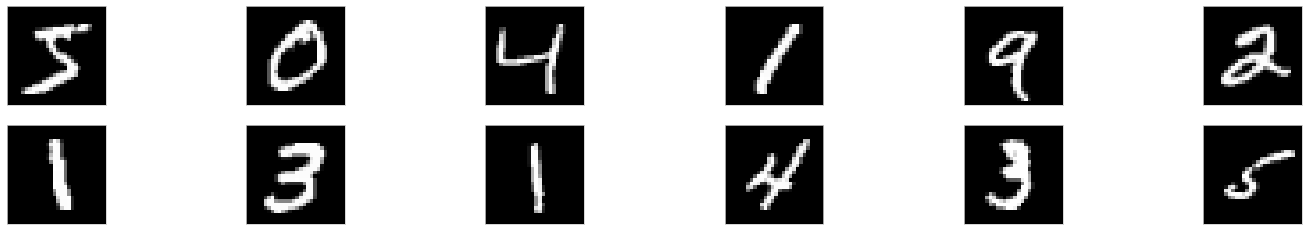

In [3]:
# obtain one batch of training images
images = []
for i in range(12):
    images.append(train_data[i][0].numpy()) #Ignore label and to numpy

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].reshape(1,28,28)), cmap='gray')

##Define Module Architecture

Encoder and Decoder separatly just in case.

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 10)
        self.fc22 = nn.Linear(400, 10)
        self.fc3 = nn.Linear(10, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        #Return vector of means and variances for latent space
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) #mu logvar

    def reparameterize(self, mu, logvar):
        #Probe point from given distribution
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std 

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

##Check GPU aviability

In [6]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


##Instanciate model

In [0]:
# Put net to model object
model = VAE()
if gpu:
    model.cuda()
# Predefined loss function
criterion = vae_loss
# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
# Load some variable for test (we dont care about labels)
features, labels = next(iter(test_gen))
if gpu:
    features = features.cuda()

#Check if size is correct, should be batch_size x no_features
print(features.shape)

# Show values after passing throught untrained network 
model.forward(features)[:1]

torch.Size([64, 1, 28, 28])


(tensor([[0.5263, 0.5561, 0.5598,  ..., 0.5137, 0.5761, 0.5428],
         [0.5362, 0.4561, 0.4762,  ..., 0.4958, 0.5448, 0.4820],
         [0.5393, 0.5033, 0.5406,  ..., 0.4941, 0.5661, 0.5562],
         ...,
         [0.5704, 0.5269, 0.4515,  ..., 0.4711, 0.4523, 0.6073],
         [0.5350, 0.4913, 0.5597,  ..., 0.5682, 0.5369, 0.5299],
         [0.4080, 0.3363, 0.4930,  ..., 0.5425, 0.5914, 0.4897]],
        device='cuda:0', grad_fn=<SigmoidBackward>),)

## Train the model

In [9]:
# number of epochs
n_epochs = 5
model.train()

# Iterate on epochs 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    # iterate on data batches, discard labels
    for features, _ in train_gen:
        # move tensors to GPU if CUDA is available
        if gpu:
            features = features.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs throught the model
        output, mu, logvar = model.forward(features)
        # calculate the batch loss by compering to initial features
        loss = criterion(output, features, mu, logvar)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss , mulitply by batchsize, no idea why
        train_loss += loss.item() * features.size(0)
       
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f}'.format(epoch, train_loss))
    torch.save(model.state_dict(), 'vae_model.pt')

Epoch: 1 	Training Loss: 529027015.3125
Epoch: 2 	Training Loss: 459654929.7500
Epoch: 3 	Training Loss: 449789499.2891
Epoch: 4 	Training Loss: 444788989.2188
Epoch: 5 	Training Loss: 441288070.9688


##Get z vectors for test set

In [0]:
#Set model to evaluation 
model.eval() 
z_vec = []
labels_vec = []

for features, labels in test_gen:
    if gpu:
        features = features.cuda()  

    output, mu, logvar = model.forward(features)
    z = model.reparameterize(mu, logvar).cpu().detach().numpy()
    z_vec.append(z)
    labels_vec.append(labels.numpy())
z_vec = np.concatenate(z_vec, axis=0)
labels_vec = np.concatenate(labels_vec, axis=0)

In [41]:
z_data = np.concatenate((z_vec, labels_vec.reshape(-1,1)), axis=1)
z_data.shape

(10000, 10)
(10000,)


(10000, 11)

## Find General Z values for each label

In [43]:
# Make data frame of z values 
df = pd.DataFrame(columns = ['z'+str(i) for i in range(10)] + ['label'], data = z_data)
df.head()

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,label
0,-0.891789,0.506043,1.524872,0.305031,0.501577,-1.350315,-0.272652,0.592070,1.097173,-1.470713,7.0
1,1.084439,-1.221175,1.468922,-0.826262,-1.652894,1.218596,0.452451,-0.348890,-1.021071,1.390935,2.0
2,2.333760,1.014312,0.999053,-0.151557,1.508294,-0.882514,0.033068,-0.230537,0.824305,0.115223,1.0
3,-1.117982,1.488574,-0.717824,1.113372,-0.054831,-0.324146,0.397189,2.844853,-1.402456,1.085466,0.0
4,-1.184760,0.567807,-0.632121,-0.560565,1.153196,-0.245903,0.765807,-0.634263,1.162184,0.206610,4.0


In [44]:
#Get averge Z values of 
grouped_df = df.groupby(['label']).mean()
grouped_df

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9
label,,,,,,,,,,
0.0,-1.110076,0.319089,-0.164670,0.108622,-0.095060,0.255127,-0.364203,1.503470,-0.049039,1.288320
1.0,1.897709,-0.234627,0.420134,0.190759,0.437146,0.231620,0.018522,-0.276404,-0.378784,-0.247597
2.0,0.030965,0.042003,0.526380,1.171043,-0.541876,-0.404980,0.088218,-0.843298,-0.517817,0.599774
3.0,0.157849,-0.275957,0.120155,-0.554199,-1.322027,-0.834454,-0.187212,0.110683,-0.400983,-0.190175
4.0,-0.428713,-0.563033,-0.834709,0.069911,1.303737,0.148627,0.379799,-0.666193,0.036861,-0.194721
5.0,0.025738,0.300152,-0.343709,-0.723263,-0.370936,0.729370,-0.869531,0.314283,-0.225267,0.048263
6.0,0.303131,-0.199458,-0.585236,0.775447,0.303260,0.664655,0.820139,0.695583,-0.370632,1.475512
7.0,-0.311036,0.762778,0.846820,0.276206,0.724146,-0.249508,-0.263068,0.333638,-0.268107,-1.280614
8.0,0.218691,-0.263367,-1.070426,0.594293,-0.743835,0.947174,-0.276623,-0.084850,-0.397248,-0.547246


## Try to generate numbers

In [74]:
z_8 = grouped_df.loc[8].to_numpy()
z_9 = grouped_df.loc[9].to_numpy()
z_8_9 = (z_8+z_9)/2
z_8_9

array([-0.03401798, -0.03076126, -0.91960452,  0.16904427,  0.04555434,
        0.5661195 , -0.10162508,  0.00614031, -0.43293339, -0.74768119])

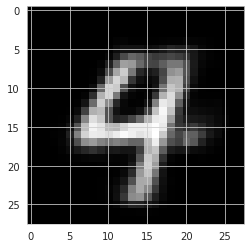

In [79]:
#z = [[-1.110076,	0.319089,	-0.164670,	0.108622,	-0.095060,	0.255127,	-0.364203,	1.503470,	-0.049039,	1.288320]] # perfect 0
#z = [[-0.286727,	0.201844,	-0.768783,	-0.256205,	0.834944,	0.185065,	0.073373,	0.097130,	-0.468618,	-0.948116]] # perfect 6
z = grouped_df.loc[4].to_numpy()
z_tensor = torch.Tensor(z).cuda()
out = model.decode(z_tensor).cpu().detach().numpy()

plt.imshow(np.squeeze(out.reshape(1,28,28)), cmap='gray')

In [61]:
g = torch.Tensor([[1,2,3,4]])

torch.rand_like(g)

tensor([[0.4824, 0.9807, 0.8446, 0.1951]])